In [1]:
from __future__ import division, print_function

# Python imports
import itertools
import numpy as np # Matrix and vector computation package
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator so that the tutorial is reproducable
#np.random.seed(seed=1)

In [2]:
# Create dataset
nb_train = 2000  # Number of training samples
# Addition of 2 n-bit numbers can result in a n+1 bit number
sequence_len = 5  # Length of the binary sequence
batch_size = 20

def create_sample(nb1, nb2, sequence_len):
    format_str = '{:0' + str(sequence_len) + 'b}' # Transform integer in binary format
    # Convert to binary representation.
    # Note that binary numbers are added from right to left.
    x1 = np.asarray([int(b) for b in format_str.format(nb1)])
    x2 = np.asarray([int(b) for b in format_str.format(nb2)])
    t = np.asarray([int(b) for b in format_str.format(nb1+nb2)])
    return x1, x2, t

def create_dataset(nb_samples, sequence_len):
    """Create a dataset for binary addition and return as input, targets."""
    max_int = 2**(sequence_len-1) # Maximum integer that can be added
    nb_inputs = 2  # Add 2 binary numbers
    nb_outputs = 1  # Result is 1 binary number
    X = np.zeros((nb_samples, sequence_len, nb_inputs))  # Input samples
    T = np.zeros((nb_samples, sequence_len, nb_outputs))  # Target samples
    # Fill up the input and target matrix
    for i in xrange(nb_samples):
        # Generate random numbers to add
        nb1 = np.random.randint(0, max_int)
        nb2 = np.random.randint(0, max_int)
        # Get the binary representation
        x1, x2, t = create_sample(nb1, nb2, sequence_len)
        # Fill current input and target row.
        X[i,:,0] = x1
        X[i,:,1] = x2
        T[i,:,0] = t
    return X, T

# Create training samples
X_train, T_train = create_dataset(nb_train, sequence_len)
print('X_train shape: {0}'.format(X_train.shape))
print('T_train shape: {0}'.format(T_train.shape))

X_train shape: (2000, 5, 2)
T_train shape: (2000, 5, 1)


In [3]:

 # Show an example input and target
def printSample(x1, x2, t, y=None):
    """Print a sample in a more visual way."""
    x1_str = ''.join([str(int(d)) for d in x1])
    x2_str = ''.join([str(int(d)) for d in x2])
    t_str = ''.join([str(int(d)) for d in t])
    line_str = '-'*sequence_len
    if not y is None:
        y_str = ''.join([str(int(d)) for d in y])
    print('x1:   {:s}   {:2d}'.format(x1_str, int(x1_str, 2)))
    print('x2: + {:s}   {:2d} '.format(x2_str, int(x2_str, 2)))
    print('      ' + line_str + '   --')
    print('t:  = {:s}   {:2d}'.format(t_str, int(t_str, 2)))
    if not y is None:
        print('y:  = {:s}'.format(y_str))
    
# Print the first sample
x1, x2, t = create_sample(37, 43, sequence_len)
print('x1: ', x1)
print('x2: ', x2)
print('t: ', t)
printSample(x1, x2, t)

x1:  [1 0 0 1 0 1]
x2:  [1 0 1 0 1 1]
t:  [1 0 1 0 0 0 0]
x1:   100101   37
x2: + 101011   43 
      -----   --
t:  = 1010000   80


In [4]:
def truncNormal(size, stdev, mean=0.0):
    """Return samples from a trunctuated normal."""
    lower = mean - 2 * stdev  # Lower cutoff
    upper = mean + 2 * stdev  # Upper cutoff$
    return scipy.stats.truncnorm.rvs(
        (lower - mean) / stdev, (upper - mean) / stdev, 
        loc=mean, scale=stdev, size=size)

truncNormal((2,3), stdev=0.0001)

array([[ -1.99133924e-04,   1.44888456e-04,   2.26960996e-05],
       [  1.85685183e-04,   4.88238100e-05,   1.88640791e-04]])

In [5]:
input_size = 2
state_size = 3
output_size = 1

# Create training samples
X_train, T_train = create_dataset(nb_train, sequence_len)
print('X_train shape: {0}'.format(X_train.shape))
print('T_train shape: {0}'.format(T_train.shape))

# Define input parameters
W_x = truncNormal((input_size, state_size), stdev=0.001)
# Define recurrence parameters
W_rec = truncNormal((state_size, state_size), stdev=0.0001)
b_rec = np.zeros((1, state_size))
# Define output parameters
W_y = truncNormal((state_size, output_size), stdev=0.001)
b_y = np.zeros((1, output_size))

def forward_step(x_k, s_kmin1):
    """Compute the forward pass of one step."""
    s_k = np.tanh(x_k.dot(W_x) + s_kmin1.dot(W_rec) + b_rec)
    y_k = 1.0 / (1 + np.exp(-(s_k.dot(W_y) + b_y)))
    return s_k, y_k

def cost(Y, T):
    """Compute the total cost at the output."""
    # Normalise of the number of samples and sequence length.
    # Add a small number (1e-99) because Y can become 0 if the network learns
    #  to perfectly predict the output. log(0) is undefined.
    return - np.sum(np.multiply(T, np.log(Y+1e-99)) + np.multiply((1-T), np.log(1-Y+1e-99)))

def backward_step(gy_k, gs_k, s_k, s_kmin1, x_k):
    """Compute the backward pass of one step"""
    # Process gradient coming from output
    gW_y = s_k.T.dot(gy_k)  # Gradient of W_y
    gb_y = np.sum(gy_k, axis=0)  # Gradient of b_y
    gs_k = gy_k.dot(W_y.T) + gs_k  # Gradient at output of current state
    # Process gradient through state
    gtanh = 1.0 - np.power(s_k, 2) 
    # Gradient at output of state linear function (before tanh)
    gs_k_lin = np.multiply(gtanh, gs_k)
    gW_rec = s_kmin1.T.dot(gs_k_lin)
    gb_rec = np.sum(gs_k_lin, axis=0)
    gs_kmin1 = gs_k_lin.dot(W_rec.T)
    # Gradient of input
    gW_x = x_k.T.dot(gs_k_lin)
    return gW_y, gb_y, gW_rec, gb_rec, gW_x, gs_kmin1

def forward(X):
    """Iteratively apply forward step to all states."""
    #print('\nforward')
    # Initalise state tensor (intial state is zero)
    S = np.zeros((batch_size, sequence_len+1, state_size))  # State tensor
    Y = np.zeros((batch_size, sequence_len, output_size))  # Output tensor
    # Forward through time
    # Note that binary addition is performed from right to left.
    #  So we unfold from right to left
    for i in xrange(sequence_len-1, -1, -1):
        #print('i: ', i)
        # Update the states iteratively
        # s_k, y_k = forward(x_k, s_kmin1)
        S[:,i,:], Y[:,i,:] = forward_step(X[:,i,:], S[:,i+1,:])
    return S, Y

def backward(Y, T, S, X):
    """Return the gradient of the parmeters and the inputs of this layer."""
    #print('\nbackward')
    gY = Y - T
    #print('gY: ', gY.shape)
    # Initalise gradient accumulation for parameters
    gW_x_sum = np.zeros_like(W_x)
    #print('gW_x_sum: ', gW_x_sum.shape)
    gW_rec_sum = np.zeros_like(W_rec)
    #print('gW_rec_sum: ', gW_rec_sum.shape)
    gb_rec_sum = np.zeros_like(b_rec)
    #print('gb_rec_sum: ', gb_rec_sum.shape)
    gW_y_sum = np.zeros_like(W_y)
    #print('gW_y_sum: ', gW_y_sum.shape)
    gb_y_sum = np.zeros_like(b_y)
    #print('gb_y_sum: ', gb_y_sum.shape)
    gs_k = np.zeros((1, state_size))
    #print('gs_k: ', gs_k.shape)
    # Propagate the gradients iteratively
    for i in xrange(0, sequence_len):
        #print('i: ', i)
        gy_k = gY[:,i,:]
        s_k = S[:,i+1,:]
        s_kmin1 = S[:,i,:]
        x_k = X[:,i,:]
        # Propgate the gradient back through one state
        gW_y, gb_y, gW_rec, gb_rec, gW_x, gs_k = backward_step(gy_k, gs_k, s_k, s_kmin1, x_k)
        gW_x_sum += gW_x
        gW_rec_sum += gW_rec
        gb_rec_sum += gb_rec
        gW_y_sum += gW_y
        gb_y_sum += gb_y
    return gW_x_sum, gW_rec_sum, gb_rec_sum, gW_y_sum, gb_y_sum 


#print('X_train: ', X_train.shape)
#print('T_train: ', T_train.shape)
#S, Y = forward(X_train)
#print('S: ', S.shape)
#print('Y: ', Y.shape)

#gW_x, gW_rec, gb_rec, gW_y, gb_y = backward(Y, T_train, S, X_train)

#print('gW_x: ', gW_x)
#print('gW_rec: ', gW_rec)
#print('gb_rec: ', gb_rec)
#print('gW_y: ', gW_y)
#print('gb_y: ', gb_y)

X_train shape: (2000, 5, 2)
T_train shape: (2000, 5, 1)


In [6]:
## Gradient checking
#S, Y = forward(X_train)
#gW_x, gW_rec, gb_rec, gW_y, gb_y = backward(Y, T_train, S, X_train)
#eps = 1e-7  # Set the small change to compute the numerical gradient
## Compute the numerical gradients of the parameters in all layers.
#for P, gP, name in zip([W_x, W_rec, b_rec, W_y, b_y], [gW_x, gW_rec, gb_rec, gW_y, gb_y], ['W_x', 'W_rec', 'b_rec', 'W_y', 'b_y']):
#    print('P name: ', name)
#    for i in xrange(P.shape[0]):
#        for j in xrange(P.shape[1]):
#            gparam = gP[i,j]
#            # + eps
#            P[i,j] += eps
#            plus_cost = cost(forward(X_train)[1], T_train)
#            # - eps
#            P[i,j] -= 2 * eps
#            min_cost = cost(forward(X_train)[1], T_train)
#            # reset param value
#            P[i,j] += eps
#            # calculate numerical gradient
#            grad_num = (plus_cost - min_cost)/(2*eps)
#            print('grad_num: ', grad_num)
#            print('gparam: ', gparam)
#            print('')
#            # Raise error if the numerical grade is not close to the backprop gradient
#            #if not np.isclose(grad_num, gparam):
#                #raise ValueError(
#                #    'Numerical gradient of {:.6f} is not close to the backpropagation gradient of {:.6f}!'.format(
#                #        float(grad_num), float(gparam)))
#print('No gradient errors found')

In [7]:

 # Set hyper-parameters
lmbd = 0.5  # Rmsprop lambda
learning_rate = 0.05  # Learning rate
momentum_term = 0.80  # Momentum term
eps = 1e-6  # Numerical stability term to prevent division by zero


ls_of_costs = []  # Size of the minibatches (number of samples)
nb_batches = nb_train // batch_size
print('nb_batches: ', nb_batches)

all_params = [W_x, W_rec, b_rec, W_y, b_y]
maSquare = [np.zeros_like(p) for p in all_params]  # Rmsprop moving average
Vs = [np.zeros_like(p) for p in all_params]  # Velocity

for i in xrange(100):
    for mb in xrange(nb_batches):
        X_mb = X_train[mb:mb+batch_size,:,:]  # Input minibatch
        T_mb = T_train[mb:mb+batch_size,:,:]  # Target minibatch
        V_tmp = [v * momentum_term for v in Vs]
        # Update each parameters according to previous gradient
        for P, V in zip(all_params, V_tmp):
            P += V
        # Get gradients after following old velocity
        S, Y = forward(X_mb)
        c = cost(Y, T_mb)
        ls_of_costs.append(c)
        gW_x, gW_rec, gb_rec, gW_y, gb_y = backward(Y, T_mb, S, X_mb)
        backprop_grads = [gW_x, gW_rec, gb_rec, gW_y, gb_y]
        # Update each parameter seperately
        for P, gP, ms, V, Vt  in zip(all_params, backprop_grads, maSquare, Vs, V_tmp):
            # Update the Rmsprop moving averages
            ms = lmbd * ms + (1-lmbd) * gP**2
            # Calculate the Rmsprop normalised gradient
            pGradNorm = learning_rate * gP / np.sqrt(ms + eps)
            # Update the momentum velocity
            V = Vt - pGradNorm     
            P -= pGradNorm   # Update the parameter
    
S, Y = forward(X_train[0:1,:,:])
result = np.round(Y)
print('S: ', S.shape)
print('Y: ', Y.shape)
print('result: ', result.shape)

printSample(X_train[0,:,0], X_train[0,:,1], T_train[0,:,0], result[0,:,0])

nb_batches:  100


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: overflow encountered in exp


S:  (20, 6, 3)
Y:  (20, 5, 1)
result:  (20, 5, 1)
x1:   01001    9
x2: + 00100    4 
      -----   --
t:  = 01101   13
y:  = 01010


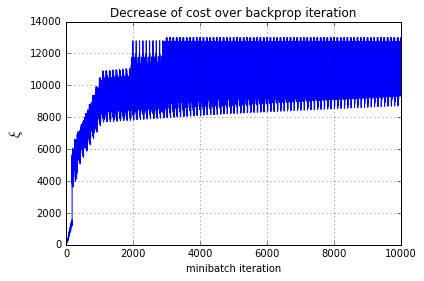

In [8]:
# Plot the cost over the iterations
plt.plot(ls_of_costs, 'b-')
plt.xlabel('minibatch iteration')
plt.ylabel('$\\xi$', fontsize=15)
plt.title('Decrease of cost over backprop iteration')
plt.grid()
plt.show()